In [4]:
import torchvision as tv
import pandas as pd
import numpy as np
import torch
from torch import nn
import time
from pprint import pprint
import matplotlib.pyplot as plt
from IPython import display

In [5]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n


In [6]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()

    loss_hist = []

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()

            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
            
            loss_hist.append(train_l_sum)
            
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        
        
    
    return loss_hist

In [7]:
BATCH_SIZE=256

In [8]:
data_transform = tv.transforms.Compose([tv.transforms.Grayscale(3), 
                                        tv.transforms.Resize((224, 224)),
                                        tv.transforms.ToTensor()])

In [9]:
train_dataset = tv.datasets.EMNIST('.', train=True, split = 'mnist', transform=data_transform, download=True)
test_dataset = tv.datasets.EMNIST('.', train=False, split = 'mnist',transform=data_transform, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:03<00:00, 140987176.03it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [10]:
ycount = torch.ones((10))

for data, label in train_dataset:
    y = int(label)
    ycount[y] += 1

In [11]:
print(ycount)

tensor([6001., 6001., 6001., 6001., 6001., 6001., 6001., 6001., 6001., 6001.])


7


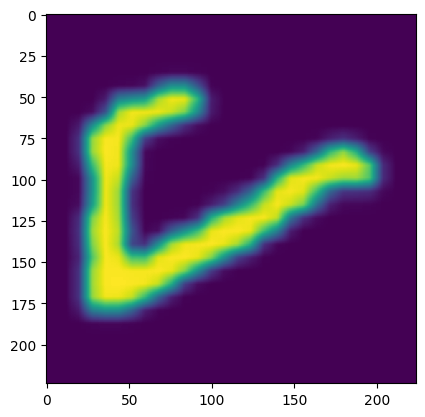

In [12]:
ex = 25

plt.imshow(train_dataset[ex][0].numpy()[0, :, :])
print(train_dataset[ex][1])

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
model = tv.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 247MB/s]


In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [17]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [18]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [20]:
model2 = tv.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 114MB/s] 


In [21]:
for param in model2.parameters():
    param.requires_grad = False

In [22]:
model2.classifier._modules['6'] = nn.Linear(in_features=4096, out_features=10)

In [23]:
print("Params to learn:")
params_to_update2 = []
for name, param in model2.named_parameters():
    if param.requires_grad == True:
        params_to_update2.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [24]:
trainer2 = torch.optim.Adam(params_to_update2, lr=0.001)

In [31]:
model3 = tv.models.inception_v3(pretrained=True)

In [32]:
for param in model3.parameters():
    param.requires_grad = False

In [33]:
model3.fc = nn.Linear(in_features=2048, out_features=10)

In [34]:
model3.aux_logits = False 

In [35]:
print("Params to learn:")
params_to_update3 = []
for name, param in model3.named_parameters():
    if param.requires_grad == True:
        params_to_update3.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [36]:
trainer3 = torch.optim.Adam(params_to_update3, lr=0.001)

In [38]:
model4 = tv.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 94.2MB/s] 


In [39]:
for param in model4.parameters():
    param.requires_grad = False

In [40]:
model4.classifier = nn.Linear(in_features=2208, out_features=10)

In [41]:
print("Params to learn:")
params_to_update4 = []
for name, param in model4.named_parameters():
    if param.requires_grad == True:
        params_to_update4.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [42]:
trainer4 = torch.optim.Adam(params_to_update4, lr=0.001)

In [43]:
loss_rn18 = train(model, train_iter, test_iter, trainer, 2)

Step 0. time since epoch: 7.710. Train acc: 0.113. Train Loss: 2.418
Step 10. time since epoch: 14.301. Train acc: 0.302. Train Loss: 2.087
Step 20. time since epoch: 20.244. Train acc: 0.464. Train Loss: 1.829
Step 30. time since epoch: 27.433. Train acc: 0.570. Train Loss: 1.624
Step 40. time since epoch: 33.584. Train acc: 0.637. Train Loss: 1.456
Step 50. time since epoch: 39.790. Train acc: 0.683. Train Loss: 1.325
Step 60. time since epoch: 46.090. Train acc: 0.715. Train Loss: 1.222
Step 70. time since epoch: 52.233. Train acc: 0.741. Train Loss: 1.135
Step 80. time since epoch: 58.549. Train acc: 0.762. Train Loss: 1.063
Step 90. time since epoch: 65.198. Train acc: 0.777. Train Loss: 1.000
Step 100. time since epoch: 71.720. Train acc: 0.789. Train Loss: 0.948
Step 110. time since epoch: 77.771. Train acc: 0.801. Train Loss: 0.903
Step 120. time since epoch: 84.223. Train acc: 0.811. Train Loss: 0.862
Step 130. time since epoch: 90.766. Train acc: 0.820. Train Loss: 0.825
Step

In [44]:
loss_vgg16 = train(model2, train_iter, test_iter, trainer2, 2)

Step 0. time since epoch: 1.918. Train acc: 0.094. Train Loss: 2.427
Step 10. time since epoch: 19.559. Train acc: 0.397. Train Loss: 1.870
Step 20. time since epoch: 36.993. Train acc: 0.552. Train Loss: 1.549
Step 30. time since epoch: 54.269. Train acc: 0.623. Train Loss: 1.344
Step 40. time since epoch: 71.619. Train acc: 0.667. Train Loss: 1.205
Step 50. time since epoch: 88.859. Train acc: 0.696. Train Loss: 1.102
Step 60. time since epoch: 106.340. Train acc: 0.717. Train Loss: 1.024
Step 70. time since epoch: 123.569. Train acc: 0.734. Train Loss: 0.962
Step 80. time since epoch: 140.860. Train acc: 0.748. Train Loss: 0.914
Step 90. time since epoch: 158.476. Train acc: 0.759. Train Loss: 0.870
Step 100. time since epoch: 175.817. Train acc: 0.768. Train Loss: 0.836
Step 110. time since epoch: 193.234. Train acc: 0.776. Train Loss: 0.807
Step 120. time since epoch: 210.688. Train acc: 0.783. Train Loss: 0.779
Step 130. time since epoch: 227.910. Train acc: 0.789. Train Loss: 0.

In [45]:
data_transform_iv3 = tv.transforms.Compose([tv.transforms.Grayscale(3), 
                                        tv.transforms.RandomVerticalFlip(1), 
                                        lambda img: tv.transforms.functional.rotate(img, -90), 
                                        tv.transforms.Resize((299, 299)),
                                        tv.transforms.ToTensor()])

In [46]:
train_dataset_iv3 = tv.datasets.EMNIST('.', train=True, split = 'mnist', transform=data_transform_iv3, download=True)
test_dataset_iv3 = tv.datasets.EMNIST('.', train=False, split = 'mnist',transform=data_transform_iv3, download=True)
train_iter_iv3 = torch.utils.data.DataLoader(train_dataset_iv3, batch_size=BATCH_SIZE)
test_iter_iv3 = torch.utils.data.DataLoader(test_dataset_iv3, batch_size=BATCH_SIZE)

In [47]:
loss_iv3 = train(model3, train_iter_iv3, test_iter_iv3, trainer3, 2)

Step 0. time since epoch: 1.739. Train acc: 0.121. Train Loss: 2.342
Step 10. time since epoch: 19.825. Train acc: 0.283. Train Loss: 2.128
Step 20. time since epoch: 37.842. Train acc: 0.401. Train Loss: 1.954
Step 30. time since epoch: 55.696. Train acc: 0.481. Train Loss: 1.806
Step 40. time since epoch: 74.027. Train acc: 0.538. Train Loss: 1.676
Step 50. time since epoch: 91.809. Train acc: 0.577. Train Loss: 1.572
Step 60. time since epoch: 109.810. Train acc: 0.605. Train Loss: 1.484
Step 70. time since epoch: 127.594. Train acc: 0.630. Train Loss: 1.412
Step 80. time since epoch: 145.839. Train acc: 0.649. Train Loss: 1.348
Step 90. time since epoch: 163.750. Train acc: 0.667. Train Loss: 1.289
Step 100. time since epoch: 181.596. Train acc: 0.680. Train Loss: 1.240
Step 110. time since epoch: 199.804. Train acc: 0.692. Train Loss: 1.197
Step 120. time since epoch: 217.729. Train acc: 0.703. Train Loss: 1.157
Step 130. time since epoch: 235.856. Train acc: 0.713. Train Loss: 1.

In [48]:
loss_dn = train(model4, train_iter, test_iter, trainer4, 2)

Step 0. time since epoch: 2.456. Train acc: 0.078. Train Loss: 2.376
Step 10. time since epoch: 27.206. Train acc: 0.356. Train Loss: 2.017
Step 20. time since epoch: 52.393. Train acc: 0.519. Train Loss: 1.739
Step 30. time since epoch: 77.509. Train acc: 0.613. Train Loss: 1.525
Step 40. time since epoch: 102.416. Train acc: 0.670. Train Loss: 1.364
Step 50. time since epoch: 127.412. Train acc: 0.710. Train Loss: 1.237
Step 60. time since epoch: 152.519. Train acc: 0.738. Train Loss: 1.138
Step 70. time since epoch: 177.631. Train acc: 0.759. Train Loss: 1.058
Step 80. time since epoch: 202.713. Train acc: 0.775. Train Loss: 0.993
Step 90. time since epoch: 227.893. Train acc: 0.789. Train Loss: 0.935
Step 100. time since epoch: 252.900. Train acc: 0.800. Train Loss: 0.886
Step 110. time since epoch: 278.062. Train acc: 0.810. Train Loss: 0.845
Step 120. time since epoch: 303.153. Train acc: 0.819. Train Loss: 0.809
Step 130. time since epoch: 328.298. Train acc: 0.827. Train Loss: 

In [49]:
loss_dn

[608.2694702148438,
 1196.0707397460938,
 1765.4360961914062,
 2329.2586669921875,
 2853.1307983398438,
 3363.47998046875,
 3857.8728942871094,
 4331.104064941406,
 4801.31201171875,
 5243.9522705078125,
 5678.938659667969,
 6099.148132324219,
 6514.121612548828,
 6908.242584228516,
 7287.476226806641,
 7655.119659423828,
 8012.367034912109,
 8353.49398803711,
 8698.270904541016,
 9040.929656982422,
 9347.521789550781,
 9665.998077392578,
 9963.714752197266,
 10261.95639038086,
 10549.707763671875,
 10832.902526855469,
 11100.07046508789,
 11351.742309570312,
 11607.558776855469,
 11858.622375488281,
 12100.258239746094,
 12343.786422729492,
 12576.534729003906,
 12811.787719726562,
 13040.273178100586,
 13252.208724975586,
 13464.470001220703,
 13675.453994750977,
 13895.491424560547,
 14109.574676513672,
 14314.35903930664,
 14510.378936767578,
 14700.937118530273,
 14891.564147949219,
 15095.098663330078,
 15286.35124206543,
 15465.91323852539,
 15645.91340637207,
 15813.87649536132

In [50]:
loss_vgg16

[621.228515625,
 1201.8742065429688,
 1749.5442504882812,
 2262.6378784179688,
 2754.1744689941406,
 3215.9999084472656,
 3658.265838623047,
 4070.436767578125,
 4485.391754150391,
 4875.637786865234,
 5266.530426025391,
 5628.911651611328,
 5969.776672363281,
 6289.861328125,
 6595.107025146484,
 6892.112274169922,
 7199.9493408203125,
 7490.352508544922,
 7771.858306884766,
 8055.372863769531,
 8328.14126586914,
 8594.178741455078,
 8844.470840454102,
 9099.401428222656,
 9336.631698608398,
 9580.999038696289,
 9802.376205444336,
 10016.14370727539,
 10241.933288574219,
 10465.518188476562,
 10669.763900756836,
 10892.984329223633,
 11113.452270507812,
 11320.690612792969,
 11509.79214477539,
 11692.884399414062,
 11887.484970092773,
 12068.562194824219,
 12269.157150268555,
 12463.001937866211,
 12645.168212890625,
 12838.970764160156,
 13028.186828613281,
 13192.503204345703,
 13373.381576538086,
 13548.832489013672,
 13725.696151733398,
 13890.883316040039,
 14055.062850952148,
 1

In [51]:
loss_rn18

[619.1005249023438,
 1209.1553955078125,
 1789.5739135742188,
 2345.6531982421875,
 2901.1768188476562,
 3439.66259765625,
 3955.8071899414062,
 4455.318450927734,
 4946.4013671875,
 5413.673492431641,
 5878.2274169921875,
 6324.319671630859,
 6770.852233886719,
 7192.184722900391,
 7598.150299072266,
 7996.014343261719,
 8379.356414794922,
 8744.80404663086,
 9112.035247802734,
 9485.672149658203,
 9834.929901123047,
 10173.653137207031,
 10505.533874511719,
 10838.360534667969,
 11164.066619873047,
 11478.039031982422,
 11767.846496582031,
 12050.947937011719,
 12337.108642578125,
 12618.332733154297,
 12888.2529296875,
 13169.0185546875,
 13423.347778320312,
 13683.690155029297,
 13931.610580444336,
 14159.552307128906,
 14387.615478515625,
 14608.149230957031,
 14848.727432250977,
 15074.3310546875,
 15286.8017578125,
 15502.407730102539,
 15719.174880981445,
 15923.22200012207,
 16138.831848144531,
 16352.599075317383,
 16551.267623901367,
 16736.322052001953,
 16921.403747558594,

In [52]:
loss_iv3

[599.5361938476562,
 1188.2188720703125,
 1770.8598022460938,
 2339.173828125,
 2899.1981811523438,
 3438.1563110351562,
 3967.0818481445312,
 4476.940704345703,
 5005.751800537109,
 5501.345642089844,
 5992.111633300781,
 6477.35009765625,
 6962.142028808594,
 7430.2386474609375,
 7893.66064453125,
 8348.152130126953,
 8792.402221679688,
 9223.438232421875,
 9654.602996826172,
 10078.465362548828,
 10504.455261230469,
 10921.924255371094,
 11320.965606689453,
 11732.239288330078,
 12124.388977050781,
 12510.421356201172,
 12880.671569824219,
 13236.227081298828,
 13606.08578491211,
 13975.100555419922,
 14329.565155029297,
 14682.955352783203,
 15021.278259277344,
 15358.211669921875,
 15696.65414428711,
 16009.877655029297,
 16322.374206542969,
 16637.325714111328,
 16959.930145263672,
 17285.269256591797,
 17586.971740722656,
 17887.21356201172,
 18182.529296875,
 18479.457061767578,
 18794.810028076172,
 19103.40692138672,
 19401.32681274414,
 19697.311737060547,
 19981.94180297851

In [53]:
import pandas as pd

In [54]:
data = [loss_rn18, loss_vgg16, loss_iv3, loss_dn] 
columns = ['Rn18', 'VGG16', 'IV3', 'DN161'] 
df = pd.DataFrame(data, columns) 
print(df)

              0            1            2            3            4    \
Rn18   619.100525  1209.155396  1789.573914  2345.653198  2901.176819   
VGG16  621.228516  1201.874207  1749.544250  2262.637878  2754.174469   
IV3    599.536194  1188.218872  1770.859802  2339.173828  2899.198181   
DN161  608.269470  1196.070740  1765.436096  2329.258667  2853.130798   

               5            6            7            8            9    ...  \
Rn18   3439.662598  3955.807190  4455.318451  4946.401367  5413.673492  ...   
VGG16  3215.999908  3658.265839  4070.436768  4485.391754  4875.637787  ...   
IV3    3438.156311  3967.081848  4476.940704  5005.751801  5501.345642  ...   
DN161  3363.479980  3857.872894  4331.104065  4801.312012  5243.952271  ...   

                460           461           462           463           464  \
Rn18   12463.718124  12519.428436  12567.975571  12612.309708  12678.623260   
VGG16  13237.115032  13292.322697  13350.315548  13396.540668  13452.749577   
I